In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [ ]:
FIT_MODEL = True

# Computer Vision Project

## Distraction detection during driving

The main goal of this notebook is to show how can we detect the distraction of a driver using a dataset of thousand of driver images. 
More precisely we want to classify the activity the driver is performing (driving, texting, talking, operating the radio etc)

### Table of Contents

* [Part 1 : Loading Dataset ](#chapter1)
    
* [Part 2 : EDA](#chapter2)

* [Part 3 : Performing a CNN model for classification](#chapter3)

* [Part 4 : Data augmentation for increase robustness](#chapter4)

* [Part 5 : Transfer Learning for increasing accuracy](#chapter4)

### Technology used :
- Python libraries : OpenCV, Tenserflow, Scikit Learn, Pandas,...
- Computer vision techniques : CNN, Data Augmentation, Transfer Learning

## Dataset sample

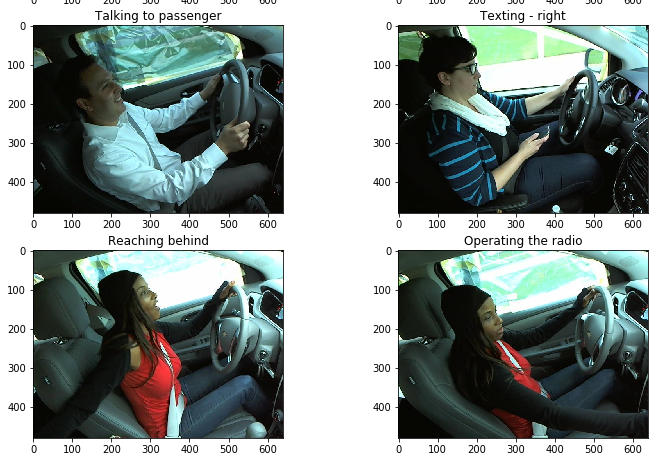

The initial Dataset is composed of a thousand of images labelized as above. The goal of this notebook is to show how to classify them using computer vision techniques

## Some check about libraries

In [ ]:
pip install keras

In [ ]:
pip install --upgrade tensorflow==2.3.1

In [ ]:
pip install --upgrade tensorflow-gpu

## Part 1 : Loading Dataset  <a class="anchor" id="chapter1"></a>

In [ ]:
import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from tensorflow import keras 

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16


dataset = pd.read_csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
dataset.head(5)

In [ ]:
# Groupby subjects
by_drivers = dataset.groupby('subject') 
# Groupby unique drivers
unique_drivers = by_drivers.groups.keys() # drivers id
print('There are : ',len(unique_drivers), ' unique drivers')
print('There is a mean of ',round(dataset.groupby('subject').count()['classname'].mean()), ' images by driver.')

### Some functions for loading and normalization

The 10 classes to classify are :
- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger

In [ ]:
NUMBER_CLASSES = 10 # 10 classes

In [ ]:
# Read with opencv
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    """
    Function that return an opencv image from the path and the right number of dimension
    """
    if color_type == 1: # Loading as Grayscale image
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3: # Loading as color image
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) # Reduce size
    return img

# Loading Training dataset
def load_train(img_rows, img_cols, color_type=3):
    """
    Return train images and train labels from the original path
    """
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('../input/state-farm-distracted-driver-detection/imgs/train/c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    """
    Load + categorical + split
    """
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10) #categorical train label
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split into train and test
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Loading validation dataset
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    """
    Same as above but for validation dataset
    """
    path = os.path.join('../input/state-farm-distracted-driver-detection/imgs/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)   
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    return test_data, test_ids

In [ ]:
img_rows = 96 # dimension of resized images
img_cols = 96
color_type = 3 # grey
nb_test_samples = 200

# loading train images
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

# loading validation images
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)

## Part 2 : EDA  <a class="anchor" id="chapter2"></a>

In [ ]:
# Statistics
# Load the list of names
names = [item[17:19] for item in sorted(glob("../input/state-farm-distracted-driver-detection/imgs/train/*/"))]
test_files_size = len(np.array(glob(os.path.join('../input/state-farm-distracted-driver-detection/imgs/test', '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

### Data visualisation

Number of images by category

In [ ]:
import plotly.express as px

px.histogram(dataset, x="classname", color="classname", title="Number of images by categories ")

--> It is well distributed

In [ ]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
px.histogram(drivers_id, x="driver_id",y="Counts" ,color="driver_id", title="Number of images by subjects ")

### Images overview

Let's take a look at the various images in the dataset.
* I'll plot an image for each of the 10 classes.

In [ ]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}


plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '../input/state-farm-distracted-driver-detection/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

## Part 3 : CNN Model  <a class="anchor" id="chapter3"></a>
Architecture :
- 3 Convolutionnal layers (with Relu, Maxpooling and dropout)
- A flatten layer
- 2 Dense layers with Relu and Dropouts
- 1 Dense layer with softmax for the classification

In [ ]:
# Number of batch size and epochs
batch_size = 40 #40
nb_epoch = 1 #10

In [ ]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
#callbacks = [checkpointer, es]

In [ ]:
def create_model():
    model = Sequential()

    ## CNN 1
    model.add(Conv2D(16,(3,3),activation='relu',input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(16,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 2
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 3
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    ## Output
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model

In [ ]:
model = create_model()

# More details about the layers
model.summary()

# Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#### Training model

In [ ]:
if FIT_MODEL:
    history = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

    #model.load_weights('saved_models/weights_best_vanilla.hdf5')
    print('History of the training',history.history)
    model.save('saved_models/model.h5')
else:
    from keras.models import load_model
    model = load_model('saved_models/model.h5')

In [ ]:
def plot_train_history(history):
    """
    Plot the validation accuracy and validation loss over epochs
    """
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plot_train_history(history)

#### Prediction on test set

In [ ]:
def plot_test_class(model, test_files, image_number, color_type=3):
    """
    Function that tests or model on test images and show the results
    """
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=0)
    with np.printoptions(precision=3, suppress=True):
        print('Image number:', image_number)
        print('Y prediction:', y_prediction)
    #print('Y prediction: {}'.format([f'{_:.3f}' for _ in y_prediction]))
    
        print('Predicted: {}, probability: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction))), np.max(y_prediction)))
        print('Actual: {}'.format(activity_map.get('c{}'.format(np.argmax(y_test[image_number, :])))))
    
    
    plt.show()

In [ ]:
for i in range(4):
    plot_test_class(model, x_test, i)

**Найдем примеры правильного и неправильного распознавания.**

In [ ]:
y_pred = model.predict(x_test)
are_matched = np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1)
proba = np.max(y_pred, axis=1)

In [ ]:
print('2 примера правильно классифицированных с высокой вероятностью принадлежности к классу')
for i in np.argsort(np.where(are_matched, proba, -np.inf))[-2:]:
    plot_test_class(model, x_test, i)

In [ ]:
print('2 примера правильно классифицированных с низкой вероятностью принадлежности к классу')
for i in np.argsort(np.where(are_matched, proba, np.inf))[:2]:
    plot_test_class(model, x_test, i)

In [ ]:
print('2 примера неправильно классифицированных с высокой (с максимально возможной) вероятностью принадлежности к классу')
for i in np.argsort(np.where(~are_matched, proba, -np.inf))[-2:]:
    plot_test_class(model, x_test, i)

In [ ]:
print('2 примера неправильно классифицированных с низкой вероятностью принадлежности к классу')
for i in np.argsort(np.where(~are_matched, proba, np.inf))[:2]:
    plot_test_class(model, x_test, i)

## Lime and Shap explanations

In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

In [ ]:
print('LIME_1: 2 примера правильно классифицированных с высокой вероятностью принадлежности к классу')
for img_num in np.argsort(np.where(are_matched, proba, -np.inf))[-2:]:
   
    explainer = lime_image.LimeImageExplainer(random_state=42)
    explanation = explainer.explain_instance(x_test[img_num], model.predict)
    plt.imshow(x_test[img_num])
    image, mask = explanation.get_image_and_mask(
        model.predict(x_test[img_num].reshape((1,96,96,3))).argmax(axis=1)[0],
        positive_only=True, hide_rest=False)
    plt.imshow(mark_boundaries(image, mask))
    plt.show()
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp, mask))
    plt.show()

In [ ]:
print('LIME_2: 2 примера правильно классифицированных с низкой вероятностью принадлежности к классу')
for img_num in np.argsort(np.where(are_matched, proba, np.inf))[:2]:
    explainer = lime_image.LimeImageExplainer(random_state=42)
    explanation = explainer.explain_instance(x_test[img_num], model.predict)
    plt.imshow(x_test[img_num])
    image, mask = explanation.get_image_and_mask(
        model.predict(x_test[img_num].reshape((1,96,96,3))).argmax(axis=1)[0],
        positive_only=True, hide_rest=False)
    plt.imshow(mark_boundaries(image, mask))
    plt.show()
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp, mask))
    plt.show()

In [ ]:
print('LIME_3: 2 примера неправильно классифицированных с высокой (с максимально возможной) вероятностью принадлежности к классу')
for img_num in np.argsort(np.where(~are_matched, proba, -np.inf))[-2:]:
    explainer = lime_image.LimeImageExplainer(random_state=42)
    explanation = explainer.explain_instance(x_test[img_num], model.predict)
    plt.imshow(x_test[img_num])
    image, mask = explanation.get_image_and_mask(
        model.predict(x_test[img_num].reshape((1,96,96,3))).argmax(axis=1)[0],
        positive_only=True, hide_rest=False)
    plt.imshow(mark_boundaries(image, mask))
    plt.show()
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp, mask))
    plt.show()

In [ ]:
print('LIME_4: 2 примера неправильно классифицированных с низкой вероятностью принадлежности к классу')
for img_num in np.argsort(np.where(~are_matched, proba, np.inf))[:2]:
    explainer = lime_image.LimeImageExplainer(random_state=42)
    explanation = explainer.explain_instance(x_test[img_num], model.predict)
    plt.imshow(x_test[img_num])
    image, mask = explanation.get_image_and_mask(
        model.predict(x_test[img_num].reshape((1,96,96,3))).argmax(axis=1)[0],
        positive_only=True, hide_rest=False)
    plt.imshow(mark_boundaries(image, mask))
    plt.show()
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp, mask))
    plt.show()